In [2]:
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch==1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.7.5   |       h06a4308_1         113 KB
    certifi-2021.5.30          |   py37h06a4308_0         139 KB
    cudatoolkit-10.2.89        |       hfd86e86_1       365.1 MB
    ninja-1.10.2               |       hff7bd54_1         1.4 MB
    pytorch-1.6.0              |py3.7_cuda1

In [2]:
import boto3 
import botocore 
import sagemaker 
config = botocore.config.Config(user_agent_extra='dlai-pds/c2/w1')
sm = boto3.client(service_name='sagemaker',config=config)
featurestore_runtime = boto3.client(service_name='sagemaker-featurestore-runtime',config=config)
sess = sagemaker.Session(sagemaker_client=sm,sagemaker_featurestore_runtime_client=featurestore_runtime)
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [3]:
raw_input_data_s3_uri = 's3://dlai-practical-data-science/data/raw/'
print(raw_input_data_s3_uri)

s3://dlai-practical-data-science/data/raw/


In [4]:
!aws s3 ls $raw_input_data_s3_uri

2021-04-30 02:21:06    8457214 womens_clothing_ecommerce_reviews.csv


In [5]:
'''To configure a Feature Store you need to setup a Feature Group.
This is the main resource containing all of the metadata related to the data stored in the Feature Store.
A Feature Group should contain a list of Feature Definitions. 
A Feature Definition consists of a name and the data type. 
The Feature Group also contains an online store configuration and an offline store configuration controlling where the data is stored.
Enabling the online store allows quick access to the latest value for a record via the GetRecord API. 
The offline store allows storage of the data in your S3 bucket. We will be using the offline store in this lab.'''

'To configure a Feature Store you need to setup a Feature Group.\nThis is the main resource containing all of the metadata related to the data stored in the Feature Store.\nA Feature Group should contain a list of Feature Definitions. \nA Feature Definition consists of a name and the data type. \nThe Feature Group also contains an online store configuration and an offline store configuration controlling where the data is stored.\nEnabling the online store allows quick access to the latest value for a record via the GetRecord API. \nThe offline store allows storage of the data in your S3 bucket. We will be using the offline store in this lab.'

In [6]:
import time 
timestamp = int(time.time())
feature_group_name = 'reviews-feature-group-' + str(timestamp)
feature_store_offline_prefix = 'reviews-feature-store-' + str(timestamp)
print('Feature group name: {}'.format(feature_group_name))
print('Feature store offline prefix in S3: {}'.format(feature_store_offline_prefix))

Feature group name: reviews-feature-group-1633687483
Feature store offline prefix in S3: reviews-feature-store-1633687483


In [7]:
from sagemaker.feature_store.feature_definition import (FeatureDefinition,FeatureTypeEnum,)
feature_definitions = [FeatureDefinition(feature_name="review_id",feature_type=FeatureTypeEnum.STRING),
                      FeatureDefinition(feature_name="date",feature_type=FeatureTypeEnum.STRING),
                      FeatureDefinition(feature_name="sentiment",feature_type=FeatureTypeEnum.STRING),
                      FeatureDefinition(feature_name="label_id",feature_type=FeatureTypeEnum.STRING),
                      FeatureDefinition(feature_name="input_ids",feature_type=FeatureTypeEnum.STRING),
                      FeatureDefinition(feature_name="review_body",feature_type=FeatureTypeEnum.STRING),
                      FeatureDefinition(feature_name="split_type",feature_type=FeatureTypeEnum.STRING)]

In [8]:
from sagemaker.feature_store.feature_group import FeatureGroup 
feature_group = FeatureGroup(name=feature_group_name,
                            feature_definitions=feature_definitions,
                            sagemaker_session=sess)
print(feature_group)

FeatureGroup(name='reviews-feature-group-1633687483', sagemaker_session=<sagemaker.session.Session object at 0x7f4e1df9f6d0>, feature_definitions=[FeatureDefinition(feature_name='review_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='sentiment', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='review_body', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='split_type', feature_type=<FeatureTypeEnum.STRING: 'String'>)])


In [9]:
'''Set the transformation parameters including the instance type, instance count, and train/validation/test split percentages. 
For the purposes of this lab, you will use a relatively small instance type. 
Please refer to this link for additional instance types that may work for your use case outside of this lab.
You can also choose whether you want to balance the dataset or not.
In this case, you will balance the dataset to avoid class imbalance in the target variable, sentiment.
Another important parameter of the model is the max_seq_length,
which specifies the maximum length of the classified reviews for the RoBERTa model.
If the sentence is shorter than the maximum length parameter, it will be padded. 
In another case, when the sentence is longer, it will be truncated from the right side.
Since a smaller max_seq_length leads to faster training and lower resource utilization, 
you want to find the smallest power-of-2 that captures 100% of our reviews.
For this dataset, the 100th percentile is 115.
However, it's best to stick with powers-of-2 when using BERT. So let's choose 128 as this is the smallest power-of-2 greater than 115. 
You will see below how the shorter sentences will be padded to a maximum length.'''

"Set the transformation parameters including the instance type, instance count, and train/validation/test split percentages. \nFor the purposes of this lab, you will use a relatively small instance type. \nPlease refer to this link for additional instance types that may work for your use case outside of this lab.\nYou can also choose whether you want to balance the dataset or not.\nIn this case, you will balance the dataset to avoid class imbalance in the target variable, sentiment.\nAnother important parameter of the model is the max_seq_length,\nwhich specifies the maximum length of the classified reviews for the RoBERTa model.\nIf the sentence is shorter than the maximum length parameter, it will be padded. \nIn another case, when the sentence is longer, it will be truncated from the right side.\nSince a smaller max_seq_length leads to faster training and lower resource utilization, \nyou want to find the smallest power-of-2 that captures 100% of our reviews.\nFor this dataset, the 

In [10]:
processing_instance_type='ml.m5.xlarge'
processing_intance_count=1
train_split_percentage=0.90
test_split_percentage=0.05
validation_split_percentage=0.05
balance_dataset=True
max_seq_length = 128

In [11]:
from sagemaker.sklearn.processing import SKLearnProcessor
processor = SKLearnProcessor(
framework_version='0.23-1',
role=role,
instance_type=processing_instance_type,
instance_count=processing_intance_count,
env={'AWS_DEFAULT_REGION':region},
max_runtime_in_seconds=7200)

In [12]:
import sys, importlib
sys.path.append('src/')
import prepare_data
if 'prepare_data' in sys.modules:
    importlib.reload(prepare_data)
input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)   
updated_correctly = False
if len(input_ids) != max_seq_length:
    print('#######################################################################################################')
    print('Please check that the function \'convert_to_bert_input_ids\' in the file src/prepare_data.py is complete.')
    print('#######################################################################################################')
    raise Exception('Please check that the function \'convert_to_bert_input_ids\' in the file src/prepare_data.py is complete.')
else:
    print('##################')
    print('Updated correctly!')
    print('##################')

    updated_correctly = True

##################
Updated correctly!
##################


In [13]:
input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)
print(input_ids)
print('Length of the sequence: {}'.format(len(input_ids)))

[0, 9226, 1152, 16, 372, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of the sequence: 128


In [15]:
from sagemaker.processing import ProcessingInput,ProcessingOutput
if (updated_correctly):
    processor.run(code="src/prepare_data.py",
                 inputs=[ProcessingInput(source=raw_input_data_s3_uri,
                                    destination='/opt/ml/processing/input/data/',
                                    s3_data_distribution_type='ShardedByS3Key')],
                 outputs=[ProcessingOutput(output_name='sentiment-train',
                                     source='/opt/ml/processing/output/sentiment/train',
                                     s3_upload_mode='EndOfJob'),
                         ProcessingOutput(output_name='sentiment-validation',
                                     source='/opt/ml/processing/output/sentiment/validation',
                                     s3_upload_mode='EndOfJob'),
                        ProcessingOutput(output_name='sentiment-test',
                                     source='/opt/ml/processing/output/sentiment/test',
                                     s3_upload_mode='EndOfJob')],
                 arguments=['--train-split-percentage', str(train_split_percentage),
                         '--validation-split-percentage', str(validation_split_percentage),
                         '--test-split-percentage', str(test_split_percentage),
                         '--balance-dataset', str(balance_dataset),
                         '--max-seq-length', str(max_seq_length),                         
                         '--feature-store-offline-prefix', str(feature_store_offline_prefix),
                         '--feature-group-name', str(feature_group_name)],
                 logs=True,
                 wait=False)
else:
    print('#######################################')
    print('Please update the code correctly above.')
    print('#######################################')


Job Name:  sagemaker-scikit-learn-2021-10-08-10-24-11-373
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://dlai-practical-data-science/data/raw/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/input/code/prepare_data.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'sentiment-train', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-train', 'LocalPath': '/opt/ml/processing/output/sentiment/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputNa

In [16]:
scikit_processing_job_name = processor.jobs[-1].describe()['ProcessingJobName']
print('Processing job name: {}'.format(scikit_processing_job_name))

Processing job name: sagemaker-scikit-learn-2021-10-08-10-24-11-373


In [17]:
print(processor.jobs[-1].describe().keys())

dict_keys(['ProcessingInputs', 'ProcessingOutputConfig', 'ProcessingJobName', 'ProcessingResources', 'StoppingCondition', 'AppSpecification', 'Environment', 'RoleArn', 'ProcessingJobArn', 'ProcessingJobStatus', 'LastModifiedTime', 'CreationTime', 'ResponseMetadata'])


In [18]:
scikit_processing_job_status = processor.jobs[-1].describe()['ProcessingJobStatus'] 
print('Processing job status: {}'.format(scikit_processing_job_status))

Processing job status: InProgress


In [19]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, scikit_processing_job_name)))

In [20]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, scikit_processing_job_name)))

In [21]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 output data</a> after the processing job has completed</b>'.format(bucket, scikit_processing_job_name, region)))

In [22]:
%%time
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name,
    sagemaker_session=sess
)
running_processor.wait(logs=False)

.......................................................................!CPU times: user 265 ms, sys: 38.7 ms, total: 304 ms
Wall time: 5min 56s


In [23]:
processing_job_description = running_processor.describe()
output_config = processing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'sentiment-train':
        processed_train_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-validation':
        processed_validation_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-test':
        processed_test_data_s3_uri = output['S3Output']['S3Uri']        
print(processed_train_data_s3_uri)
print(processed_validation_data_s3_uri)
print(processed_test_data_s3_uri)

s3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-train
s3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-validation
s3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-test


In [24]:
!aws s3 ls $processed_train_data_s3_uri/

2021-10-08 10:38:09    4894856 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [25]:
!aws s3 ls $processed_validation_data_s3_uri/

2021-10-08 10:38:09     270532 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [26]:
!aws s3 ls $processed_test_data_s3_uri/

2021-10-08 10:38:10     269235 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [27]:
!aws s3 cp $processed_train_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-train/
!aws s3 cp $processed_validation_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-validation/
!aws s3 cp $processed_test_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-test/

download: s3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-us-east-1-998345249834/sagemaker-scikit-learn-2021-10-08-10-24-11-373/output/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [28]:
feature_store_query = feature_group.athena_query()
feature_store_table = feature_store_query.table_name
query_string = """
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "{}" 
    WHERE split_type='train' 
    LIMIT 5
""".format(feature_store_table)
print('Glue Catalog table name: {}'.format(feature_store_table))
print('Running query: {}'.format(query_string))

Glue Catalog table name: reviews-feature-group-1633687483-1633689111
Running query: 
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "reviews-feature-group-1633687483-1633689111" 
    WHERE split_type='train' 
    LIMIT 5



In [30]:
output_s3_uri = 's3://{}/query_results/{}/'.format(bucket, feature_store_offline_prefix)
print(output_s3_uri)

s3://sagemaker-us-east-1-998345249834/query_results/reviews-feature-store-1633687483/


In [31]:
feature_store_query.run(
    query_string=query_string, 
    output_location=output_s3_uri 
)
feature_store_query.wait()

In [32]:
import pandas as pd
pd.set_option("max_colwidth", 100)
df_feature_store = feature_store_query.as_dataframe()
df_feature_store

,date,review_id,sentiment,label_id,input_ids,review_body
0,2021-10-08T10:32:22Z,14450,-1,0,"[0, 100, 2740, 42, 3588, 804, 4, 5, 986, 6173, 58, 6030, 14, 24, 1237, 650, 1437, 1605, 11, 5, 1...",I ordered this dress online. the previous reviews were accurate that it runs small particularly...
1,2021-10-08T10:32:22Z,15615,-1,0,"[0, 100, 74, 33, 2638, 42, 299, 114, 24, 58, 5, 5933, 7092, 15, 5, 1421, 1437, 53, 24, 21, 10, 3...",I would have loved this top if it were the length pictured on the model but it was a cropped le...
2,2021-10-08T10:32:22Z,11213,0,1,"[0, 100, 1381, 42, 15, 11, 5, 1400, 11, 5, 3023, 29, 1836, 4, 5, 6184, 16, 5690, 8, 269, 817, 47...",I tried this on in the store in the xs size. the pattern is striking and really makes you think ...
3,2021-10-08T10:32:22Z,626,-1,0,"[0, 100, 524, 27325, 3995, 30, 5, 1280, 9, 1313, 6173, 15, 42, 3588, 328, 77, 939, 829, 24, 1437...",I am floored by the amount of positive reviews on this dress! when i received it it looked noth...
4,2021-10-08T10:32:22Z,11243,-1,0,"[0, 100, 2740, 42, 9540, 142, 1437, 101, 643, 1437, 939, 21, 551, 30, 63, 27360, 4002, 328, 9574...",I ordered this coat because like others i was taken by its feminine beauty! unfortunately the...


In [33]:
df_feature_store.to_csv('./feature_store_export.tsv',
                        sep='\t',
                        index=False,
                        header=True)

In [34]:
!head -n 5 ./feature_store_export.tsv

date	review_id	sentiment	label_id	input_ids	review_body
2021-10-08T10:32:22Z	14450	-1	0	[0, 100, 2740, 42, 3588, 804, 4, 5, 986, 6173, 58, 6030, 14, 24, 1237, 650, 1437, 1605, 11, 5, 13977, 4, 939, 6329, 3568, 10, 321, 50, 132, 1437, 53, 939, 2740, 5, 204, 4, 24, 2564, 127, 13977, 8, 28097, 53, 21, 2829, 7082, 23, 5, 299, 190, 600, 939, 524, 10, 2631, 438, 4, 939, 6640, 5, 356, 1437, 53, 24, 56, 10, 4683, 147, 5, 39336, 56, 283, 4102, 227, 5, 909, 33953, 420, 5, 7050, 8, 5, 1049, 10199, 4, 31151, 1437, 5, 909, 32657, 58, 2468, 11, 484, 2127, 19, 25816, 11752, 66, 4, 939, 1835, 24, 1320, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	I ordered this dress online. the previous reviews were accurate that it runs small  particularly in the waist. i normally wear a 0 or 2  but i ordered the 4. it fit my waist and hips but was slightly loose at the top even though i am a 34c. i liked the look  but it had a hole where the seams had come apart between the black stripe a

In [35]:
!aws s3 cp ./feature_store_export.tsv s3://$bucket/feature_store/feature_store_export.tsv

upload: ./feature_store_export.tsv to s3://sagemaker-us-east-1-998345249834/feature_store/feature_store_export.tsv


In [36]:
!aws s3 ls --recursive s3://$bucket/feature_store/feature_store_export.tsv

2021-10-08 10:54:51       4854 feature_store/feature_store_export.tsv


In [37]:
feature_store_query_2 = feature_group.athena_query()
query_string_count_by_sentiment = """
SELECT sentiment, COUNT(*) AS count_reviews
FROM "{}"
GROUP BY sentiment
""".format(feature_store_table)

In [38]:
feature_store_query_2.run(
    query_string=query_string_count_by_sentiment, 
    output_location=output_s3_uri 
)
feature_store_query_2.wait()
df_count_by_sentiment = feature_store_query_2.as_dataframe()
df_count_by_sentiment

,sentiment,count_reviews
0,1,2051
1,0,2051
2,-1,2051


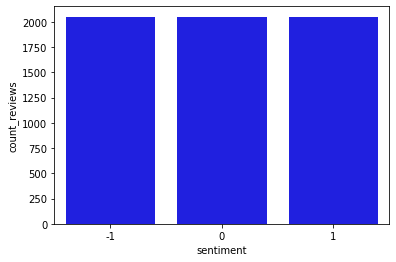

In [39]:
import seaborn as sns
sns.barplot(
    data=df_count_by_sentiment,
    x='sentiment',
    y='count_reviews',
    color="blue"
)